# (SWAG-approximated) Bayesian Neural Network

In [185]:
import jax
import distrax
import optax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from functools import partial
from sklearn.metrics import confusion_matrix
from torchvision.datasets import MNIST
from jax.flatten_util import ravel_pytree

In [173]:
from tqdm.notebook import tqdm

In [26]:
%config InlineBackend.figure_format = "retina"

In [ ]:
root = "/tmp/mnist"
mnist_train = MNIST(root, download=True, train=True)
mnist_test = MNIST(root, download=True, train=False)

In [88]:
class MLP1D(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.relu(nn.Dense(10)(x))
        x = nn.relu(nn.Dense(10)(x))
        x = nn.relu(nn.Dense(10)(x))
        x = nn.Dense(10)(x)
        return x


def bnn_log_joint(params, X, y, model):
    flatten_params, _ = ravel_pytree(params)
    logits = model.apply(params, X)
    
    log_prior = distrax.Normal(0.0, 1.0).log_prob(flatten_params).sum()
    log_likelihood = distrax.Multinomial(10, logits=logits).log_prob(y).sum()
    
    log_joint = log_prior + log_likelihood
    return log_joint

def bnn_loss_fn(params, X, y, model): return -bnn_log_joint(params, X, y, model)

In [165]:
key = jax.random.PRNGKey(314)
key_samples, key_init, key_train, key = jax.random.split(key, 4)

In [166]:
X_train = jnp.array(mnist_train.data)
y_train = jnp.array(mnist_train.targets)

n_train, *_ = X_train.shape
# "Gaussanised" MNIST
Xf_train = X_train.reshape(-1, 28 ** 2)
Xf_train = Xf_train / Xf_train.max()
Xf_train = (Xf_train - Xf_train.mean()) / Xf_train.std()

y_ohe_train = jax.nn.one_hot(y_train, 10)

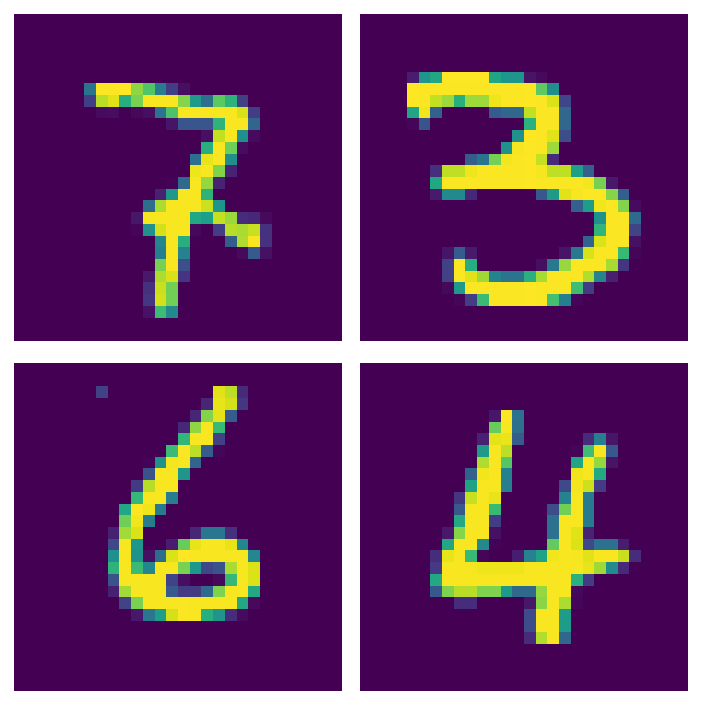

In [167]:
key = jax.random.PRNGKey(314)
key_sample, key = jax.random.split(key)
ixs = jax.random.choice(key, n_train, (4,))

fig, axs = plt.subplots(2, 2, figsize=(5, 5))
axs = axs.ravel()
for ix, ax in zip(ixs, axs):
    ax.imshow(Xf_train[ix].reshape(28, 28))
    ax.axis("off")
plt.tight_layout()

In [168]:
def update_first_moment(moment, params, n):
    moment = jax.tree_map(lambda mean, theta: (n * mean + theta) / (n + 1),
                          moment, params)
    return moment


def update_second_moment(moment, params, n):
    moment = jax.tree_map(lambda mean2, theta: (n * mean2 + theta ** 2) / (n + 1),
                          moment, params)
    return moment

In [169]:
@jax.jit
def train_step(params, opt_state, X_batch, y_batch):
    loss_fn = partial(bnn_loss_fn, X=X_batch, y=y_batch, model=model)
    loss_grad_fn = jax.value_and_grad(loss_fn)
    
    loss_val, grads = loss_grad_fn(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    return loss_val, params
    

def get_batch_train_ixs(key, num_samples, batch_size):
    """
    Obtain the training indices to be used in an epoch of
    mini-batch optimisation.
    """
    steps_per_epoch = num_samples // batch_size
    
    batch_ixs = jax.random.permutation(key, num_samples)
    batch_ixs = batch_ixs[:steps_per_epoch * batch_size]
    batch_ixs = batch_ixs.reshape(steps_per_epoch, batch_size)
    
    return batch_ixs


def train_epoch_sgd(key, params, opt_step, X, y, batch_size, epoch):
    num_samples = len(X)
    batch_ixs = get_batch_train_ixs(key, num_samples, batch_size)
    
    total_loss = 0
    num_batches = len(batch_ixs)
    
    for batch_ix in batch_ixs:
        X_batch = X[batch_ix, ...]
        y_batch = y[batch_ix, ...]
        loss, params = train_step(params, opt_step, X_batch, y_batch)
        total_loss += loss
    
    mean_loss = total_loss / num_batches
    return params, opt_step, mean_loss

In [175]:
batch_size = 500
# X_batches = Xf_train.reshape(batch_size, -1, 28 ** 2)
# y_batches = y_ohe_train.reshape(batch_size, -1, 10)

In [197]:
batch_size = 2000
num_epochs = 150
learning_rate = 1e-3
tx = optax.adam(learning_rate=learning_rate)

model = MLP1D()

batch = jnp.ones((batch_size, 28 ** 2))
params = model.init(key_init, batch)
opt_state = tx.init(params)

losses = []
for e in tqdm(range(num_epochs)):
    _, key_train = jax.random.split(key_train)
    params, opt_state, loss = train_epoch_sgd(key_train, params, opt_state,
                                              Xf_train, y_ohe_train, batch_size, e)
    losses.append(loss)

  0%|          | 0/150 [00:00<?, ?it/s]

In [198]:
yhat_train = model.apply(params, Xf_train).argmax(axis=1)

In [199]:
confusion_matrix(y_train, yhat_train)

array([[5776,    1,   10,    4,    8,   24,   48,    3,   42,    7],
       [   1, 6565,   30,   12,   14,    4,   14,   18,   77,    7],
       [  56,   35, 5537,   36,   31,   36,   53,   35,  124,   15],
       [  21,   18,  116, 5513,    3,  242,   12,   49,  109,   48],
       [   6,   14,    9,    1, 5631,    7,   74,    7,   17,   76],
       [  28,    4,   17,   65,   22, 5114,   77,   10,   62,   22],
       [  19,    7,    7,    1,   39,   28, 5796,    0,   21,    0],
       [  15,   36,   56,   42,   33,    9,    2, 5932,   15,  125],
       [  15,   24,   27,   37,   25,   79,   93,    6, 5475,   70],
       [  33,   12,    6,   32,  205,   47,    1,   73,   44, 5496]])

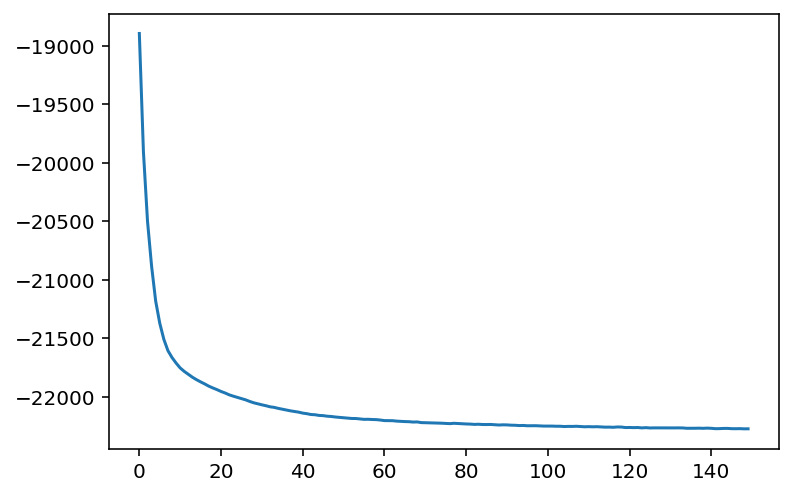

In [200]:
plt.plot(losses)